<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/MITDeepLearning/introtodeeplearning/blob/master/lab2/PT_Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab2/PT_Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2025 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 2: Computer Vision

# Part 1: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [2]:
# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

We'll also install Comet. If you followed the instructions from Lab 1, you should have your Comet account set up. Enter your API key below.

In [ ]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = ""

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

# Set GPU for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/comet_ml/error_tracking/shutdown.py:22: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  client = sentry_sdk.Hub.current.client


In [4]:
# start a first comet experiment for the first part of the lab
comet_ml.init(api_key = COMET_API_KEY, project_name="6S191_lab2_part1_NN")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, tensorflow, keras, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/fnu-yash/6s191-lab2-part1-nn/08cb230db0b64dcf918eda668d4fcc82



## 1.1 MNIST dataset

Let's download and load the dataset and display a few random samples from it:

In [5]:
# Download and transform the MNIST dataset
transform = transforms.Compose([
    # Convert images to PyTorch tensors which also scales data from [0,255] to [0,1]
    transforms.ToTensor()
])

# Download training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


The MNIST dataset object in PyTorch is not a simple tensor or array. It's an iterable dataset that loads samples (image-label pairs) one at a time or in batches. In a later section of this lab, we will define a handy DataLoader to process the data in batches.

In [6]:
image, label = train_dataset[0]
print(image.size())  # For a tensor: torch.Size([1, 28, 28])
print(label)  # For a label: integer (e.g., 5)

torch.Size([1, 28, 28])
5


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

{'web': 'https://www.comet.com/api/image/download?imageId=91ae4243831c4569a48a2f8c7c1a61da&experimentKey=08cb230db0b64dcf918eda668d4fcc82',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=91ae4243831c4569a48a2f8c7c1a61da&experimentKey=08cb230db0b64dcf918eda668d4fcc82',
 'imageId': '91ae4243831c4569a48a2f8c7c1a61da'}

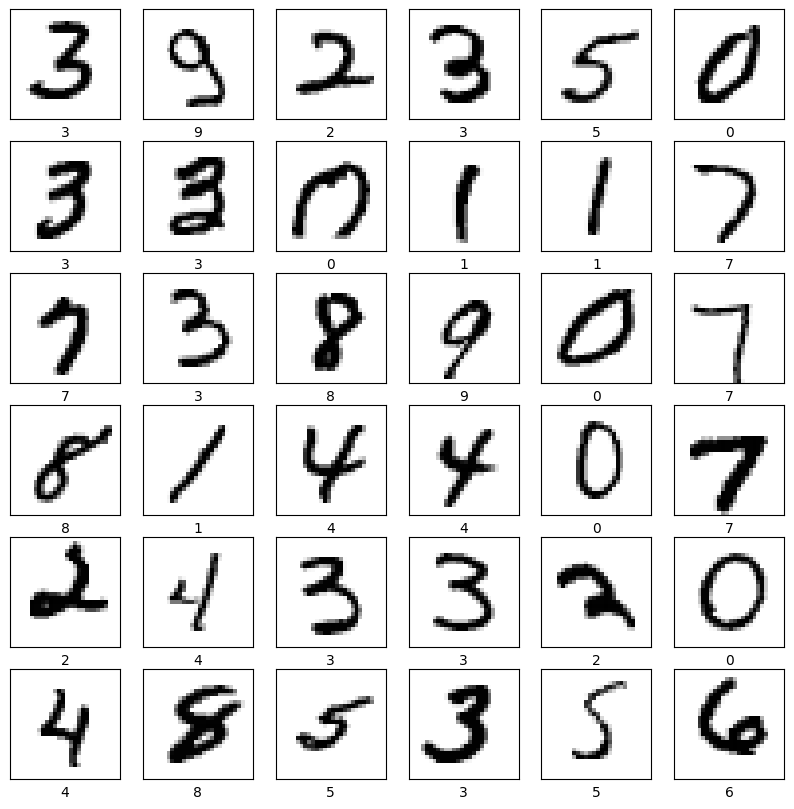

In [7]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
comet_model_1.log_figure(figure=plt)

## 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the the `torch.nn` modules, defining the model using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). Note how we first use a [`nn.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple network.

In [8]:
def build_fc_model():
    fc_model = nn.Sequential(
        # First define a Flatten layer
        nn.Flatten(),

        # '''TODO: Define the activation function for the first fully connected (Dense/Linear) layer.'''
        nn.Linear(28 * 28, 128),
        # '''TODO'''
        nn.ReLU(),

        # '''TODO: Define the second Linear layer to output the classification probabilities'''
        nn.Linear(128, 10)
        )
    return fc_model

fc_model_sequential = build_fc_model()

As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model.**

Let's take a step back and think about the network we've just created. The first layer in this network, `nn.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `nn.Linear` layers. These are fully-connected neural layers. The first `nn.Linear` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!

### Embracing subclassing in PyTorch

Recall that in Lab 1, we explored creating more flexible models by subclassing [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). This technique of defining models is more commonly used in PyTorch. We will practice using this approach of subclassing to define our models for the rest of the lab.

In [9]:
# Define the fully connected model
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)

        # '''TODO: Define the activation function for the first fully connected layer'''
        self.relu = nn.ReLU()
        # '''TODO: Define the second Linear layer to output the classification probabilities'''
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)

        # '''TODO: Implement the rest of forward pass of the model using the layers you have defined above'''
        '''TODO'''
        x = self.relu(x)
        x = self.fc2(x)

        return x

fc_model = FullyConnectedModel().to(device) # send the model to GPU

### Model Metrics and Training Parameters

Before training the model, we need to define components that govern its performance and guide its learning process. These include the loss function, optimizer, and evaluation metrics:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics that we want to use to monitor the training and testing steps. In this example, we'll define and take a look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [10]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_model.parameters(), lr=0.1)

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_dataset`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training. This dataset consists of a (image, label) tuples that we will iteratively access in batches.

In Lab 1, we saw how we can use the [`.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) method to optimize losses and train models with stochastic gradient descent. In this section, we will define a function to train the model using `.backward()` and `optimizer.step()` to automatically update our model parameters (weights and biases) as we saw in Lab 1.

Recall, we mentioned in Section 1.1 that the MNIST dataset can be accessed iteratively in batches. Here, we will define a PyTorch [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) that will enable us to do that.

In [11]:
# Create DataLoaders for batch processing
BATCH_SIZE = 64
trainset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0

        for images, labels in trainset_loader:
            # Move tensors to GPU so compatible with model
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = fc_model(images)

            # Clear gradients before performing backward pass
            optimizer.zero_grad()
            # Calculate loss based on model predictions
            loss = loss_function(outputs, labels)
            # Backpropagate and update model parameters
            loss.backward()
            optimizer.step()

            # multiply loss by total nos. of samples in batch
            total_loss += loss.item()*images.size(0)

            # Calculate accuracy
            predicted = torch.argmax(outputs, dim=1)  # Get predicted class
            correct_pred += (predicted == labels).sum().item()  # Count correct predictions
            total_pred += labels.size(0) # Count total predictions

        # Compute metrics
        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")


In [13]:
# TODO: Train the model by calling the function appropriately
EPOCHS = 5
train(fc_model, trainset_loader, _, optimizer=optimizer, epochs=EPOCHS) # TODO

comet_model_1.end()

Epoch 1, Loss: 0.43570086113611856, Accuracy: 0.8857
Epoch 2, Loss: 0.2237015698512395, Accuracy: 0.9361
Epoch 3, Loss: 0.16785854093631108, Accuracy: 0.9513
Epoch 4, Loss: 0.13440229664246242, Accuracy: 0.9615
Epoch 5, Loss: 0.11355543098251025, Accuracy: 0.9684


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : jade_meerkat_9501
COMET INFO:     url                   : https://www.comet.com/fnu-yash/6s191-lab2-part1-nn/08cb230db0b64dcf918eda668d4fcc82
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=16Qsmh16Hav49iUJ7gipWuoEYoUxXhjxH
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import com

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, iterating over the `testset_loader` allows us to access our test images and test labels. And to evaluate accuracy, we can check to see if the model's predictions match the labels from this loader.

Since we have now trained the mode, we will use the eval state of the model on the test dataset.

In [14]:
'''TODO: Use the model we have defined in its eval state to complete
and call the evaluate function, and calculate the accuracy of the model'''

def evaluate(model, dataloader, loss_function):
    # Evaluate model performance on the test dataset
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0
    # Disable gradient calculations when in inference mode
    with torch.no_grad():
        for images, labels in testset_loader:
            # TODO: ensure evalaution happens on the GPU
            images, labels = images.to(device), labels.to(device)

            # TODO: feed the images into the model and obtain the predictions (forward pass)
            outputs = model(images)

            loss = loss_function(outputs, labels)

            # TODO: Calculate test loss
            test_loss += loss.item() * images.size(0)

          #  '''TODO: make a prediction and determine whether it is correct!'''
            # TODO: identify the digit with the highest probability prediction for the images in the test dataset.
            predicted = torch.argmax(outputs, dim=1)

            # TODO: tally the number of correct predictions
            correct_pred += sum(predicted == labels).item()

            # TODO: tally the total number of predictions
            total_pred += labels.size(0)

    # Compute average loss and accuracy
    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    return test_loss, test_acc

# TODO: call the evaluate function to evaluate the trained model!!
test_loss, test_acc = evaluate(fc_model, testset_loader, loss_function)

print('Test accuracy:', test_acc)

Test accuracy: 0.9648


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data.

What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to define convolutional layers and [`nn.MaxPool2D`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model. You can decide to use `nn.Sequential` or to subclass `nn.Module`based on your preference.

In [15]:
### Basic CNN in PyTorch ###

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # TODO: Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 24, 3)

        # TODO: Define the first max pooling layer
        self.pool1 = nn.MaxPool2d(2)

        # TODO: Define the second convolutional layer
        self.conv2 = nn.Conv2d(24, 36, 3)

        # TODO: Define the second max pooling layer
        self.pool2 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(36 * 5 * 5, 128)
        self.relu = nn.ReLU()

        # TODO: Define the Linear layer that outputs the classification
        # logits over class labels. Remember that CrossEntropyLoss operates over logits.
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # First convolutional and pooling layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # '''TODO: Implement the rest of forward pass of the model using the layers you have defined above'''
        #     '''hint: this will involve another set of convolutional/pooling layers and then the linear layers'''
        '''TODO'''
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# Instantiate the model
cnn_model = CNN().to(device)
# Initialize the model by passing some data through
image, label = train_dataset[0]
image = image.to(device).unsqueeze(0)  # Add batch dimension → Shape: (1, 1, 28, 28)
output = cnn_model(image)
# Print the model summary
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Train and test the CNN model

Earlier in the lab, we defined a `train` function. The body of the function is quite useful because it allows us to have control over the training model, and to record differentiation operations during training by computing the gradients using `loss.backward()`. You may recall seeing this in Lab 1 Part 1.

We'll use this same framework to train our `cnn_model` using stochastic gradient descent. You are free to implement the following parts with or without the train and evaluate functions we defined above. What is most important is understanding how to manipulate the bodies of those functions to train and test models.

As we've done above, we can define the loss function, optimizer, and calculate the accuracy of the model. Define an optimizer and learning rate of choice. Feel free to modify as you see fit to optimize your model's performance.

In [16]:
# Rebuild the CNN model
cnn_model = CNN().to(device)

# Define hyperparams
batch_size = 64
epochs = 7
optimizer = optim.SGD(cnn_model.parameters(), lr=1e-2)

# TODO: instantiate the cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# Redefine trainloader with new batch size parameter (tweak as see fit if optimizing)
trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

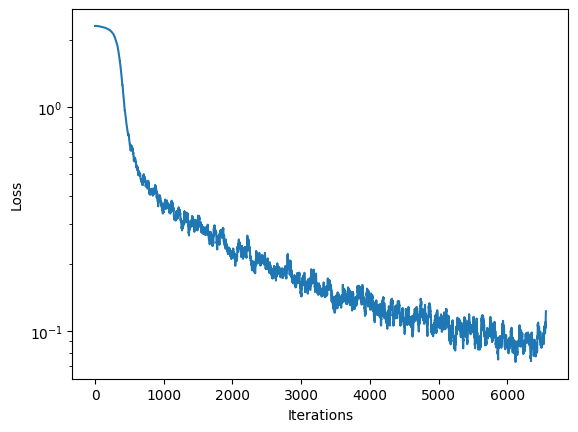

100%|██████████| 938/938 [00:11<00:00, 84.71it/s]

Epoch 7, Loss: 0.0, Accuracy: 0.9720


{'web': 'https://www.comet.com/api/image/download?imageId=659d6b34af8e45ce9b4309d3127f673f&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=659d6b34af8e45ce9b4309d3127f673f&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'imageId': '659d6b34af8e45ce9b4309d3127f673f'}

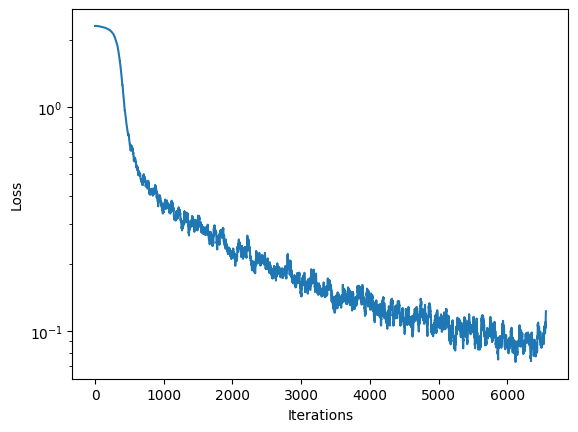

In [17]:
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')

# Initialize new comet experiment
comet_ml.init(project_name="6.s191lab2_part1_CNN")
comet_model_2 = comet_ml.Experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# Training loop!
cnn_model.train()

for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0

    # First grab a batch of training data which our data loader returns as a tensor
    for idx, (images, labels) in enumerate(tqdm(trainset_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        # TODO: feed the images into the model and obtain the predictions
        logits = cnn_model(images)

        # TODO: compute the categorical cross entropy loss using the predicted logits
        loss = loss_function(logits, labels)

        # Get the loss and log it to comet and the loss_history record
        loss_value = loss.item()
        comet_model_2.log_metric("loss", loss_value, step=idx)
        loss_history.append(loss_value) # append the loss to the loss_history record
        plotter.plot(loss_history.get())

        # Backpropagation/backward pass
        # '''TODO: Compute gradients for all model parameters and propagate backwads
        #     to update model parameters. remember to reset your optimizer!'''
        # TODO: reset optimizer
        # TODO: compute gradients
        # TODO: update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the prediction and tally metrics
        predicted = torch.argmax(logits, dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)

    # Compute metrics
    total_epoch_loss = total_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")

comet_model_2.log_figure(figure=plt)

### Evaluate the CNN Model

Now that we've trained the model, let's evaluate it on the test dataset.

In [18]:
'''TODO: Evaluate the CNN model!'''
test_loss, test_acc = evaluate(cnn_model, testset_loader, loss_function)

print('Test accuracy:', test_acc)

Test accuracy: 0.9746


What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model?

Feel free to click the Comet links to investigate the training/accuracy curves for your model.

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images.

In [19]:
test_image, test_label = test_dataset[0]
test_image = test_image.to(device).unsqueeze(0)

# put the model in evaluation (inference) mode
cnn_model.eval()
predictions_test_image = cnn_model(test_image)

With this function call, the model has predicted the label of the first image in the testing set. Let's take a look at the prediction:

In [20]:
print(predictions_test_image)

tensor([[ -0.8490,  -2.1345,   5.9179,   5.6728,  -2.7864,  -2.1428, -11.0348,
          14.3911,  -0.3983,   2.5781]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a  distribution over the 10 digit classes. Thus, these numbers describe the model's predicted likelihood that the image corresponds to each of the 10 different digits.

Let's look at the digit that has the highest likelihood for the first image in the test dataset:

In [21]:
'''TODO: identify the digit with the highest likelihood prediction for the first
    image in the test dataset. '''
predictions_value = predictions_test_image.cpu().detach().numpy() #.cpu() to copy tensor to memory first
prediction = np.argmax(predictions_value)
print(prediction)

7


So, the model is most confident that this image is a "???". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

Label of this digit is: 7


{'web': 'https://www.comet.com/api/image/download?imageId=178f6f785dd34482bef8d065ef44a7a6&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=178f6f785dd34482bef8d065ef44a7a6&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'imageId': '178f6f785dd34482bef8d065ef44a7a6'}

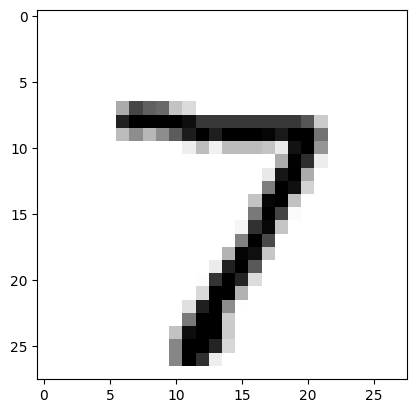

In [22]:
print("Label of this digit is:", test_label)
plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)
comet_model_2.log_figure(figure=plt)

It is! Let's visualize the classification results on the MNIST dataset. We will plot images from the test dataset along with their predicted label, as well as a histogram that provides the prediction probabilities for each of the digits.

Recall that in PyTorch the MNIST dataset is typically accessed using a DataLoader to iterate through the test set in smaller, manageable batches. By appending the predictions, test labels, and test images from each batch, we will first gradually accumulate all the data needed for visualization into singular variables to observe our model's predictions.

In [23]:
# Initialize variables to store all data
all_predictions = []
all_labels = []
all_images = []

# Process test set in batches
with torch.no_grad():
    for images, labels in testset_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = cnn_model(images)

        # Apply softmax to get probabilities from the predicted logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted classes
        predicted = torch.argmax(probabilities, dim=1)

        all_predictions.append(probabilities)
        all_labels.append(labels)
        all_images.append(images)

all_predictions = torch.cat(all_predictions)  # Shape: (total_samples, num_classes)
all_labels = torch.cat(all_labels)            # Shape: (total_samples,)
all_images = torch.cat(all_images)            # Shape: (total_samples, 1, 28, 28)

# Convert tensors to NumPy for compatibility with plotting functions
predictions = all_predictions.cpu().numpy()  # Shape: (total_samples, num_classes)
test_labels = all_labels.cpu().numpy()       # Shape: (total_samples,)
test_images = all_images.cpu().numpy()       # Shape: (total_samples, 1, 28, 28)

{'web': 'https://www.comet.com/api/image/download?imageId=e66384cad1724198b8911ba81fed5fe9&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=e66384cad1724198b8911ba81fed5fe9&experimentKey=95f00e5d7c014c8c83c910a984368d9e',
 'imageId': 'e66384cad1724198b8911ba81fed5fe9'}

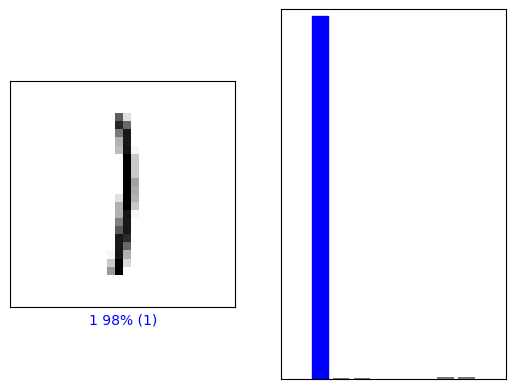

In [24]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 40 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions, test_labels)
comet_model_2.log_figure(figure=plt)

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are grey. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : misty_acorn_736
COMET INFO:     url                   : https://www.comet.com/fnu-yash/6-s191lab2-part1-cnn/95f00e5d7c014c8c83c910a984368d9e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6566] : (0.00899883359670639, 2.3136160373687744)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=16Qsmh16Hav49iUJ7gipWuoEYoUxXhjxH
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 4
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COM

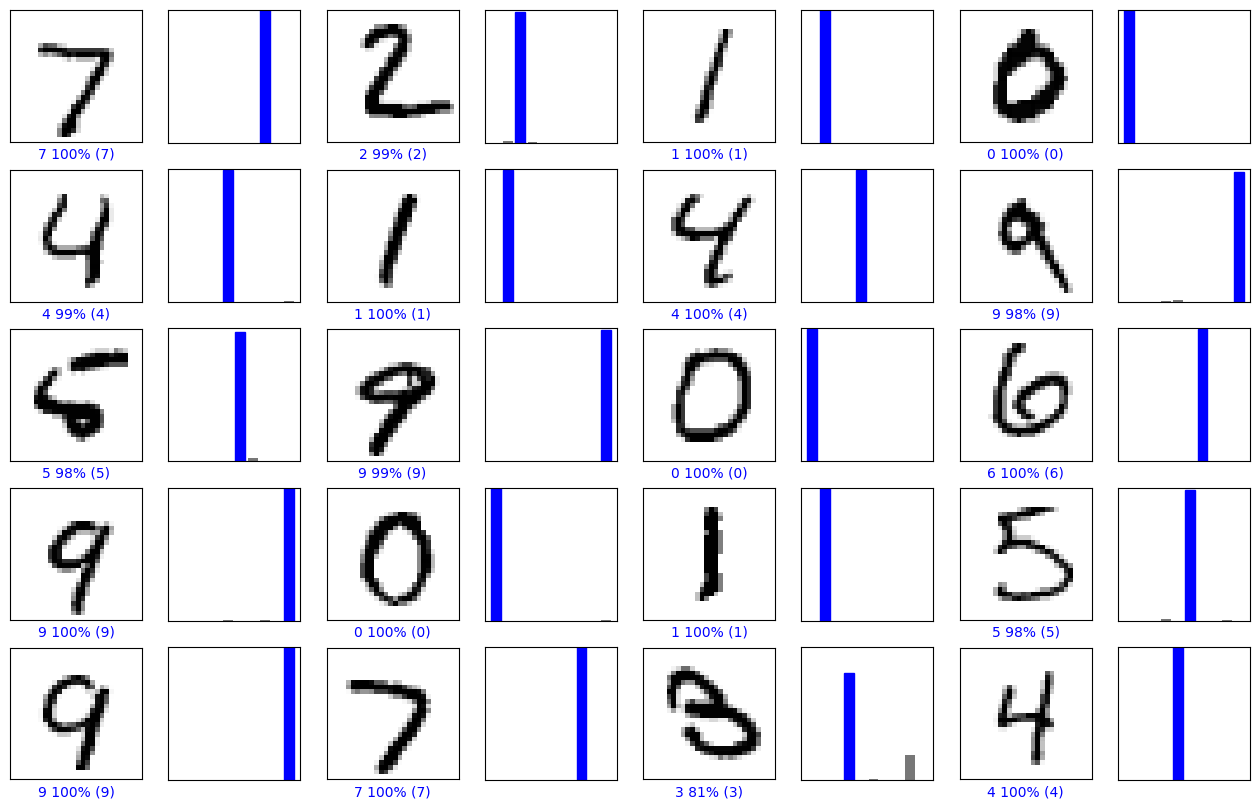

In [25]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)
comet_model_2.log_figure(figure=plt)
comet_model_2.end()

## 1.5 Conclusion
In this part of the lab, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.). The next part of the lab explores another application of CNNs, facial detection, and some drawbacks of AI systems in real world applications, like issues of bias.